In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
from popsed import prior
import gc

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift


**Input parameters : logmstar, InvSigmoid(kappa1_sfh), InvSigmoid(kappa2_sfh), InvSigmoid(kappa3_sfh), log10(fburst), log10(tburst), logzsol, log10(dust1), log10(dust2), dust_index, log10(redshift)**

We still need penalty on logzsol and dust_index

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

### Try to test how kappa transforms into beta

In [71]:
from popsed.nde import _inv_beta_cdf, _beta_cdf
def gen_truth(N_samples=5000):
    ncomp = 4
    priors = prior.load_priors([
            # flat dirichilet priors for SFH
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.6),
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.6),
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.6),
            # uniform priors on the mass fraction of burst
            prior.TruncatedNormalPrior(0, 1, 0.1, 0.6, label='fburst'),
            # uniform priors on star-burst lookback time
            prior.TruncatedNormalPrior(1e-2, 13.27, 14, 7, label='tburst'),
            # uniform priors on log-metallicity, absolute Z
#             prior.UniformPrior(-2.6, 0.3, label='logzsol'),
            prior.TruncatedNormalPrior(-2.6, 0.3, -0.7, 0.9, label='logzsol'),
            # uniform priors on dust1
            prior.UniformPrior(0., 3., label='dust1'),
            # uniform priors on dust2
#             prior.BiGaussianPrior([0.3, 1.0], [[0.02, 0], [0, 0.05]], p1=0.3, label='dust2'),
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.8, label='dust2'),
            # uniform priors on dust_index
            prior.TruncatedNormalPrior(-3., 1., 2, 2, label='dust_index'),
            # uniformly sample redshift
#             prior.TruncatedNormalPrior(0, 0.78, 0.18, 0.1, label='redshift')
#             prior.TruncatedNormalPrior(7.5, 13, 11.0, 0.7, label='logmstar')
#             prior.TruncatedNormalPrior(0., 1.5, 0.08, 0.05, label='redshift')
        ])
    
    _thetas_unt = np.array([priors.sample() for i in range(N_samples)])
    for i in range(3):
        _thetas_unt[:, i:i + 1] = _inv_beta_cdf(_thetas_unt[:, i:i + 1], 3 - i, 1)
    _thetas = np.hstack([
               prior.FlatDirichletPrior(4).transform(_thetas_unt[:, 0:3]), 
               _thetas_unt[:, 3:]])
    
    return _thetas, _thetas_unt

In [65]:
nsa_sample = np.load('./nsa_sedflow/nsa_sedflow.posterior.reorganized.npy')

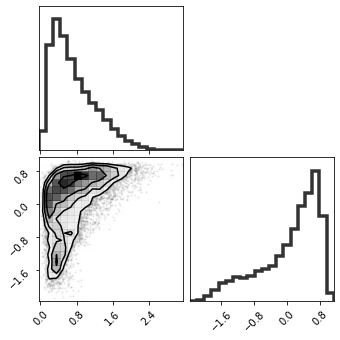

In [70]:
corner.corner(nsa_sample[:, 8:10]);

In [72]:
# z_mass_mock = np.load('./NDE/GAMA/NMF/z_mass_mock.npy')
z_mass_mock = np.load('./reference_catalog/GAMA/gama_clean_z_mass_lambdar.npy')[:, :2]
# z_mass_mock = np.load('./reference_catalog/GAMA/gama_clean_z_mass_dr3_apmatch.npy')[:, :2]
z_mass_mock = z_mass_mock[(z_mass_mock[:, 1] > 7.5) & (z_mass_mock[:, 1] < 13) & (z_mass_mock[:, 0] < 0.8)]
z_mass_mock = z_mass_mock[np.random.randint(0, len(z_mass_mock), 50000)]

In [73]:
_thetas, _thetas_unt = gen_truth(N_samples=len(z_mass_mock)) # slow

In [81]:
_thetas[:, 7:10] = nsa_sample[:, 7:10][np.random.randint(0, len(nsa_sample), 50000)]
_thetas_unt[:, 6:9] = nsa_sample[:, 7:10][np.random.randint(0, len(nsa_sample), 50000)]

In [82]:
params = np.hstack([_thetas, z_mass_mock])
params_unt = np.hstack([_thetas_unt, z_mass_mock])

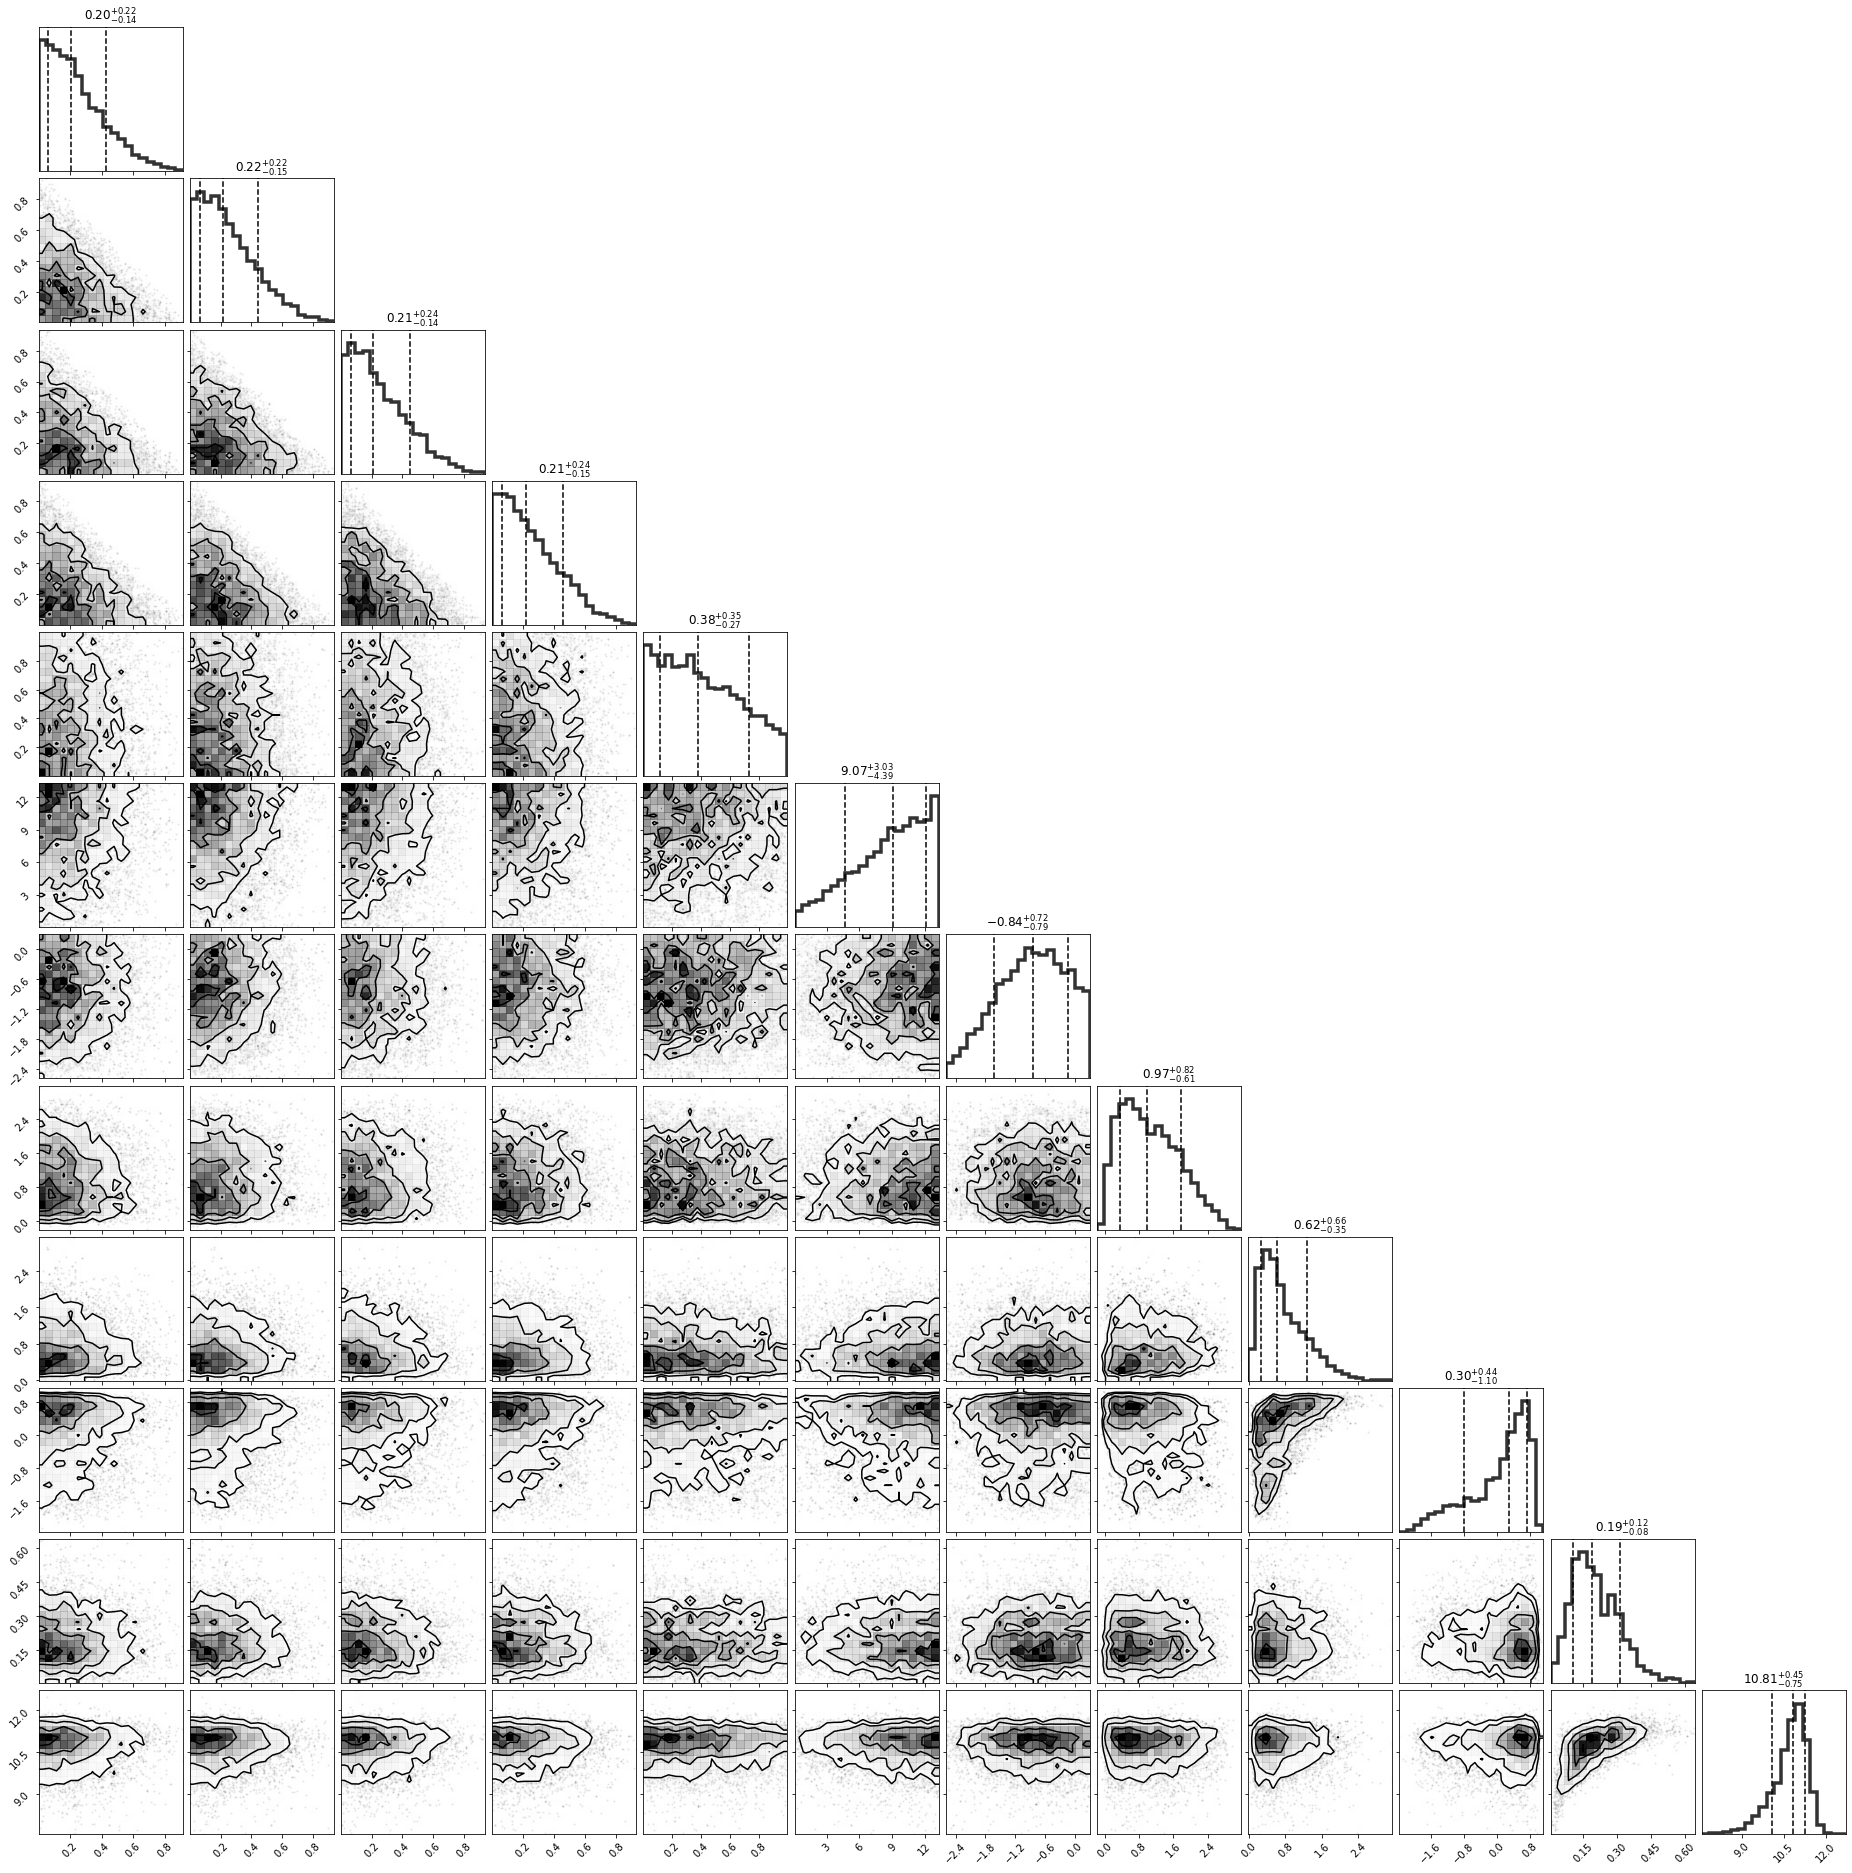

In [83]:
figure = corner.corner(params[np.random.randint(0, len(params), 5000)], #params, 
                       quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [88]:
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
name = 'NMF'
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=['.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol',
                 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'],
    device='cuda', use_speclite=True)


gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)

noise = None # 'gama' #'snr' #None # 'gama'
noise_model_dir = './noise_model/gama_noise_model_mag_dr3_apmatch.npy'

In [89]:
# params_unt = np.load('./NDE/GAMA/NMF/mock_params.npy')
# params = np.load('./NDE/GAMA/NMF/mock_params_trans.npy')

In [90]:
test_par = torch.Tensor(params_unt).to('cuda')
mags = speculator._predict_mag_with_mass_redshift(test_par, noise=None, #SNR=5,
                                           noise_model_dir=noise_model_dir).detach().cpu().numpy()
np.save('./NDE/GAMA/NMF/mock_params.npy', params_unt)
np.save('./NDE/GAMA/NMF/mock_mags_no_noise.npy', mags)
del mags
torch.cuda.empty_cache()
gc.collect()

mags = speculator._predict_mag_with_mass_redshift(test_par, noise='gama', SNR=1,
                                           noise_model_dir=noise_model_dir).detach().cpu().numpy()
np.save('./NDE/GAMA/NMF/mock_mags_gama_apmatch_noise.npy', mags)
del mags
torch.cuda.empty_cache()
gc.collect()

mags = speculator._predict_mag_with_mass_redshift(test_par, noise='snr', SNR=5,
                                           noise_model_dir=noise_model_dir).detach().cpu().numpy()
np.save('./NDE/GAMA/NMF/mock_mags_snr_5.npy', mags)
del mags
torch.cuda.empty_cache()
gc.collect()

0

#### Load GAMA photometry catalog

In [91]:
from astropy.table import Table
from popsed.utils import flux2mag, sigma_flux2mag

In [99]:
X_data = np.load('./NDE/GAMA/NMF/mock_mags_gama_apmatch_noise.npy')[:, :]
print('Total number of samples:', len(X_data))

Total number of samples: 50000


In [93]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [94]:
# Intrinsic loss
X_data = torch.Tensor(X_data[:, :])
# X_data = X_data[np.random.choice(np.arange(len(X_data)), 50000)]
print('Total number of samples:', len(X_data))

# Determine the intrinsic sampling loss
X_datas = []
for i in range(2):
    ind = np.random.randint(0, len(X_data), 10000)
    X_datas.append(X_data[ind].to('cuda'))
    
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.002, 'scaling': 0.9})
intr_loss = L(X_datas[0], X_datas[1]).item()
print("Intrinsic sampling loss:", intr_loss)
# Intrinsic sampling loss: 0.07

# del X_data
gc.collect()
torch.cuda.empty_cache()

Total number of samples: 50000
Intrinsic sampling loss: 0.20643365383148193


In [95]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [96]:
_prior_NDE = speculator.bounds.copy()
_prior_NDE[-2] = np.array([0., 0.8])
_prior_NDE[-1] = np.array([7.5, 13.])

In [97]:
_prior_NDE

array([[ 1.000e-10,  1.000e+00],
       [ 1.000e-10,  1.000e+00],
       [ 1.000e-10,  1.000e+00],
       [ 1.000e-10,  1.000e+00],
       [ 1.000e-02,  1.327e+01],
       [-2.600e+00,  3.000e-01],
       [ 1.000e-10,  3.000e+00],
       [ 1.000e-10,  3.000e+00],
       [-3.000e+00,  1.000e+00],
       [ 0.000e+00,  8.000e-01],
       [ 7.500e+00,  1.300e+01]])

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar, 

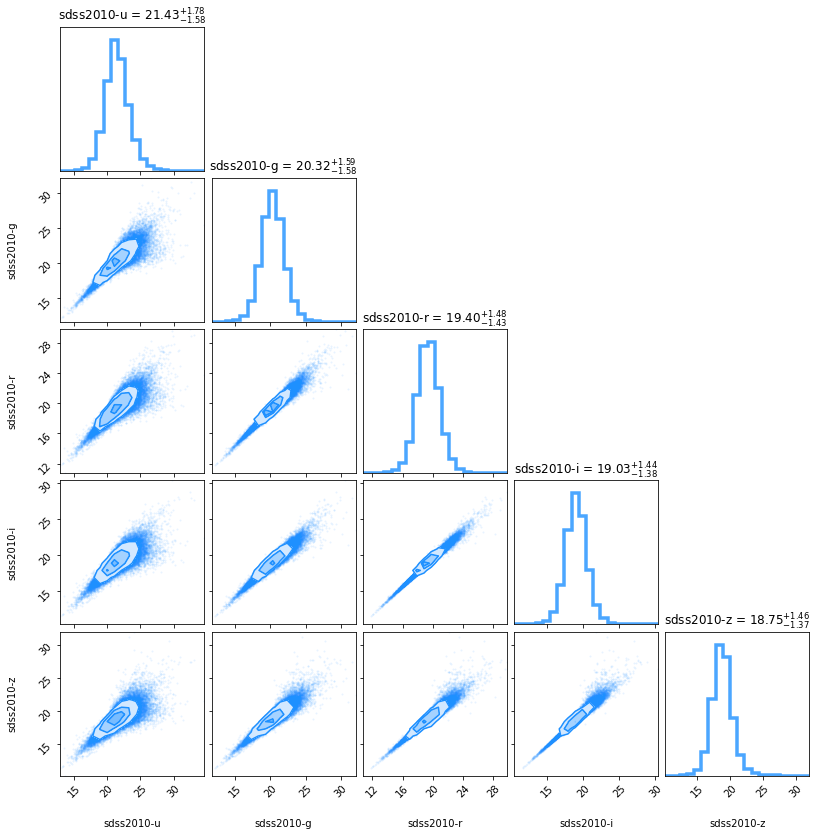

In [100]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = gama_filters

figure = corner.corner(X_data,
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

In [9]:
# noise = 'gama'
# noise = None
# true_params_unt = np.load('./NDE/GAMA/NMF/mock_params.npy')
# true_params_unt = true_params_unt[np.random.randint(0, len(true_params_unt), 5000)]

p = 1
blur = 0.1, loss=0.07
blur = 0.01, loss=0.196
blur = 0.002, loss=0.204

p = 2
blur = 0.1, loss=0.012
blur = 0.01, loss=0.02
blur = 0.002, loss=0.0184

In [77]:
# min_loss = 0.11

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [101]:
X_train, X_vali = train_test_split(X_data, test_size=0.15)
if name == 'NMF_ZH':
    Y_train = torch.ones(len(X_train), 12)
else:
    Y_train = torch.ones(len(X_train), 11)

### now we provide the redshift distribution to it

In [102]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

In [104]:
seed = 42
np.random.seed(seed)

_bounds = speculator.bounds.copy()
_bounds = np.zeros_like(_bounds)
_bounds = np.vstack([-np.abs(np.random.normal(size=len(_bounds)) / 20), 
                   np.abs(np.random.normal(size=len(_bounds)) / 20)]).T

_stds = np.ones(len(_bounds))

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name=name,
                                              num_transforms=20,  # 10
                                              num_bins=50,  # how smashed it is. 10
                                              hidden_features=100,  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=True, 
                                              NDE_prior=_prior_NDE,#np.vstack([_prior_NDE[:-2], _prior_NDE[-1:]])
                                             )

In [105]:
NDE_theta.build(
    Y_train,
    X_train,
    filterset=gama_filters,
    z_score=False,
    optimizer='adam')
NDE_theta.load_validation_data(X_vali)
NDE_theta.bounds = speculator.bounds
NDE_theta.params_name = speculator.params_name

print('Total number of params in the model:', 
      sum(p.numel() for p in NDE_theta.net.parameters() if p.requires_grad))

NDE_theta.external_redshift_data = None

[-0.00681201  0.01116113  0.06134625  0.02106908 -0.00549469 -0.00198084
 -0.07346169  0.03419039  0.03308453  0.04396988 -0.02246155]
Total number of params in the model: 2479030


In [106]:
# del X_data
gc.collect()
torch.cuda.empty_cache()

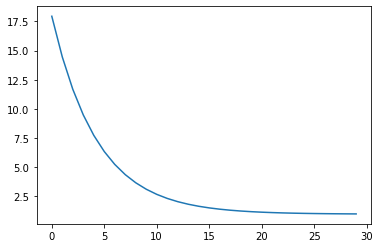

In [37]:
plt.plot([0.95 + 17 * 0.75**(0.8 * i) for i in range(30)])

# plt.xlim(15, 35)
# plt.ylim(0.8, 3)

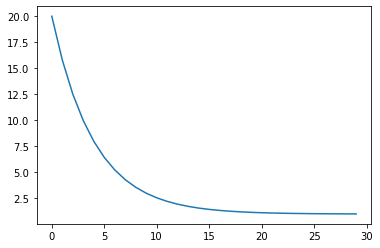

In [118]:
plt.plot([1 + 19 * np.exp(-0.25 * i) for i in range(30)])
# plt.xlim(15, 35)
# plt.ylim(0.8, 3)

In [38]:
lrs = []
noise = 'gama'
max_epochs = 35
steps = 20
blurs = [0.3, 0.2, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05] + [0.002] * 30
scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=3e-4, #3e-4, #4e-4, #2e-4, #3e-4, #8e-4, #5e-4,
                                                steps_per_epoch=steps,
                                                epochs=max_epochs,
                                                anneal_strategy='cos',
                                                div_factor=10, final_div_factor=100)
for i in range(35):
    for epoch in range(steps):
        lrs.append(NDE_theta.optimizer.param_groups[0]['lr'])
        scheduler.step()

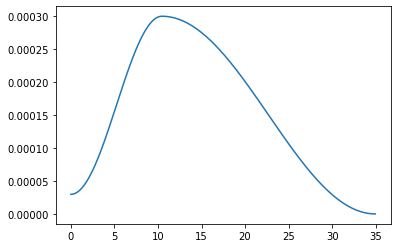

In [39]:
plt.plot(np.arange(len(lrs)) / steps, lrs)

min_loss = 0.20619666576385498

In [107]:
noise = 'gama'
max_epochs = 30
steps = 30
blurs = [0.3, 0.2, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05] + [0.002] * 30

scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=3e-4, #3e-4, #4e-4, #2e-4, #3e-4, #8e-4, #5e-4,
                                                steps_per_epoch=steps,
                                                epochs=max_epochs,
                                                anneal_strategy='cos',
                                                div_factor=10, final_div_factor=100)

for i, epoch in enumerate(range(max_epochs)):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    print('    blur:', blurs[i])
    np.save(f'./NDE/GAMA/NMF/sample_anneal_3e-4/sample_anneal_{i}.npy', NDE_theta.sample(5000).detach().cpu().numpy())
    NDE_theta.train(n_epochs=steps,
                    speculator=speculator,
                    add_penalty=False,
                    n_samples=10000,
                    noise=noise, noise_model_dir=noise_model_dir, SNR=1 + 17 * 0.8**(0.9 * i),
                    sinkhorn_kwargs={
                        'p': 1, 'blur': blurs[i], 'scaling': 0.9},
                    scheduler=scheduler, detect_anomaly=False,
                    )
np.save(f'./NDE/GAMA/NMF/sample_anneal_3e-4/sample_anneal_{i+1}.npy', NDE_theta.sample(5000).detach().cpu().numpy())

    Epoch 0
    lr: 3.0000000000000024e-05
    blur: 0.3


Loss = 7.453 (train), 7.376 (vali), 6.973 (bad ratio): 100%|███████████| 30/30 [01:00<00:00,  2.01s/epochs]


    Epoch 1
    lr: 3.820151867012196e-05
    blur: 0.2


Loss = 4.051 (train), 3.929 (vali), 5.246 (bad ratio): 100%|███████████| 30/30 [01:02<00:00,  2.07s/epochs]


    Epoch 2
    lr: 6.180955751757875e-05
    blur: 0.1


Loss = 1.415 (train), 1.431 (vali), 3.935 (bad ratio): 100%|███████████| 30/30 [01:04<00:00,  2.16s/epochs]


    Epoch 3
    lr: 9.795564585537213e-05
    blur: 0.1


Loss = 0.354 (train), 0.347 (vali), 4.541 (bad ratio): 100%|███████████| 30/30 [01:03<00:00,  2.11s/epochs]


    Epoch 4
    lr: 0.0001422478900782534
    blur: 0.1


Loss = 0.233 (train), 0.240 (vali), 4.485 (bad ratio): 100%|███████████| 30/30 [01:02<00:00,  2.08s/epochs]


    Epoch 5
    lr: 0.00018930460621680684
    blur: 0.05


Loss = 0.270 (train), 0.273 (vali), 4.374 (bad ratio): 100%|███████████| 30/30 [01:06<00:00,  2.21s/epochs]


    Epoch 6
    lr: 0.00023340821596044028
    blur: 0.05


Loss = 0.242 (train), 0.242 (vali), 4.313 (bad ratio): 100%|███████████| 30/30 [01:06<00:00,  2.20s/epochs]


    Epoch 7
    lr: 0.000269199955179788
    blur: 0.05


Loss = 0.231 (train), 0.227 (vali), 4.183 (bad ratio): 100%|███████████| 30/30 [01:05<00:00,  2.20s/epochs]


    Epoch 8
    lr: 0.00029233098509790753
    blur: 0.002


Loss = 0.284 (train), 0.293 (vali), 4.352 (bad ratio): 100%|███████████| 30/30 [01:24<00:00,  2.80s/epochs]


    Epoch 9
    lr: 0.00029999813686425446
    blur: 0.002


Loss = 0.281 (train), 0.278 (vali), 4.360 (bad ratio): 100%|███████████| 30/30 [01:24<00:00,  2.81s/epochs]


    Epoch 10
    lr: 0.0002982130855743032
    blur: 0.002


Loss = 0.275 (train), 0.285 (vali), 4.338 (bad ratio): 100%|███████████| 30/30 [01:24<00:00,  2.80s/epochs]


    Epoch 11
    lr: 0.00029312054961950584
    blur: 0.002


Loss = 0.282 (train), 0.273 (vali), 4.061 (bad ratio):   7%|▊           | 2/30 [00:07<01:44,  3.73s/epochs]


KeyboardInterrupt: 

(0.16925566203909365, 0.6)

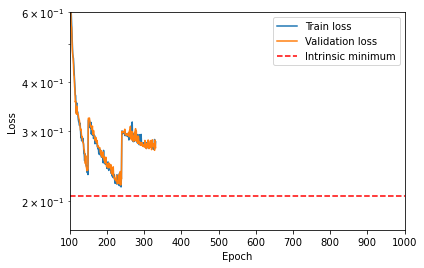

In [108]:
NDE_theta.plot_loss(0.206)
plt.yscale('log')

plt.xlim(100, 1000)
plt.ylim(0, 0.6)

In [109]:
samples = NDE_theta.sample(5000)
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()
_samples = np.hstack([prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]),
                      _samples_unt[:, 3:-1], 
                      _samples_unt[:, -1:]])

0 5000
>40 0


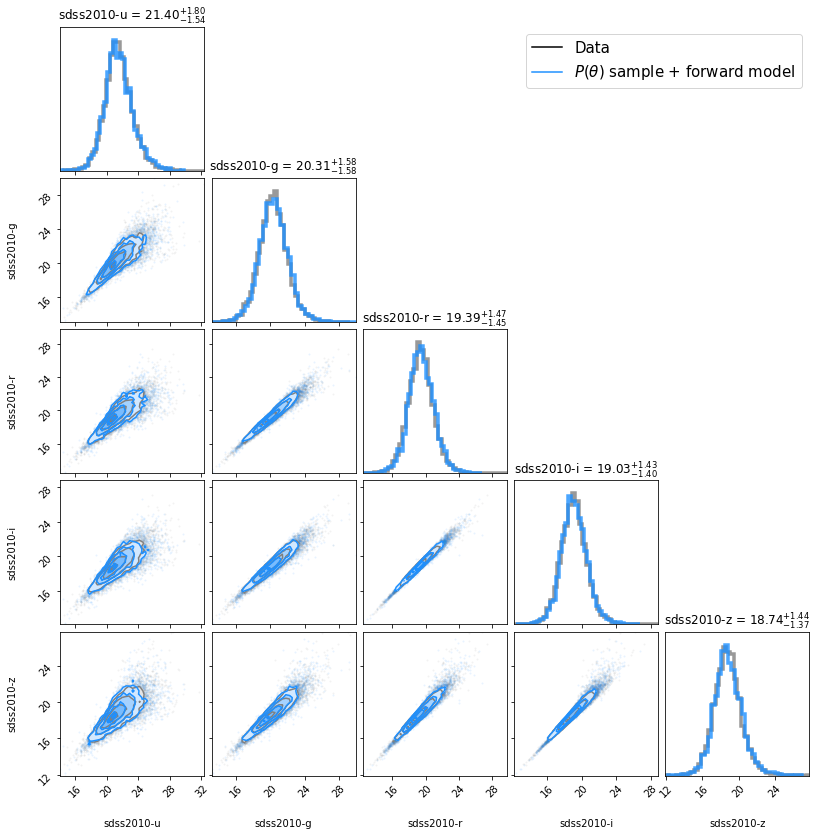

In [110]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = gama_filters

figure = corner.corner(X_vali,#.cpu().detach().numpy(), 
                       color='gray', labels=labels, bins=40,
                       smooth=0.2, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(
#     inverse_transform_nmf_params_given_z(samples, NDE_theta.NDE_prior, NDE_theta.cdf_z), 
    inverse_transform_nmf_params(samples, NDE_theta.NDE_prior),
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir, SNR=1,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>40', np.any(mags > 40, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=40,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.2, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [111]:
true_params_unt = np.load('./NDE/GAMA/NMF/mock_params.npy')
true_params_unt = true_params_unt[np.random.randint(0, len(true_params_unt), 5000)]
true_params = np.hstack([prior.FlatDirichletPrior(4).transform(true_params_unt[:, :3]),
                      true_params_unt[:, 3:-1], 
                      true_params_unt[:, -1:]])

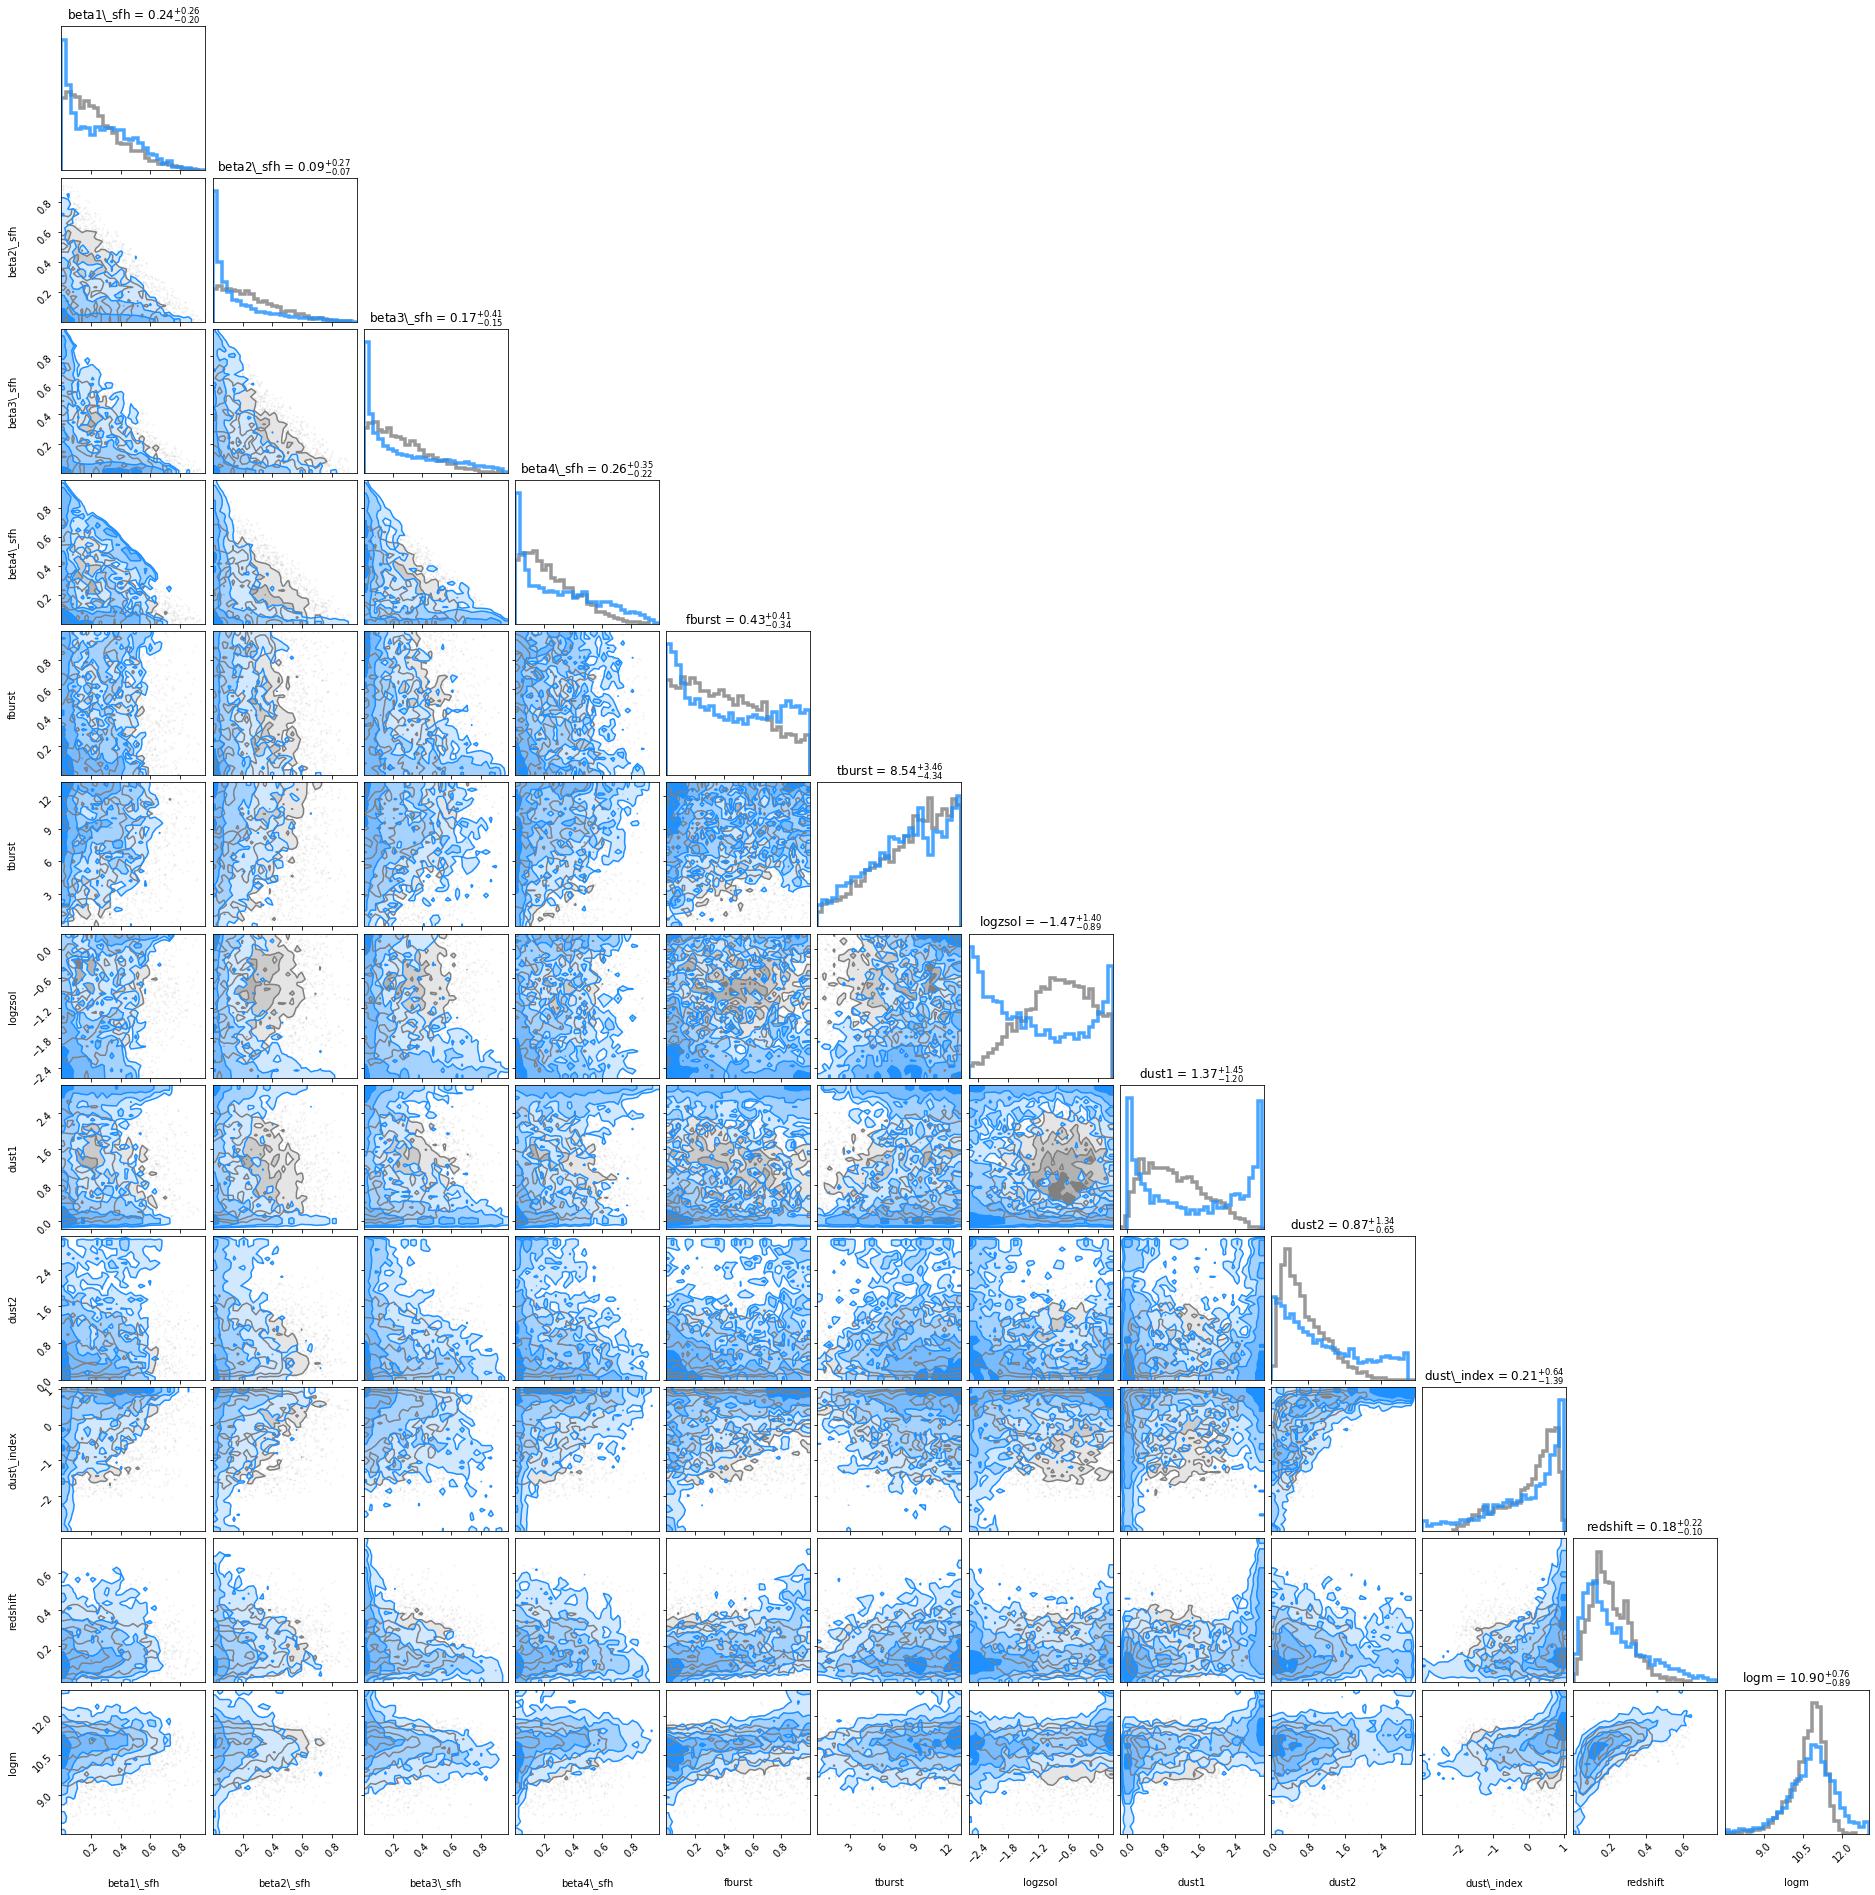

In [112]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

figure = corner.corner(true_params, 
                  labels=_labels, bins=30,
                  color='gray', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)


nf_plot = corner.corner(_samples, 
                        fig=figure,
                  labels=_labels, bins=30,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

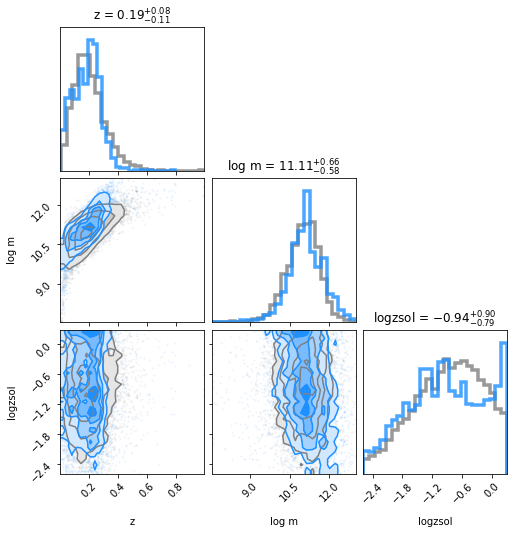

In [52]:
z_mass_met = np.hstack([true_params[:, -2:], true_params[:, 6:7]])
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
#                        range=[[0, 1], [8, 13], [-2, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples[:, -2:-1], _samples[:, -1:], _samples[:, 6:7]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [46]:
np.sort(true_params[:, -2])

array([0.00657144, 0.0066278 , 0.00664884, ..., 0.97983915, 0.98794556,
       0.9928388 ])

(array([193., 466., 620., 746., 738., 645., 528., 369., 229., 154., 125.,
         67.,  36.,  32.,  12.,  10.,   8.,   5.,   3.,   1.,   6.,   2.,
          0.,   1.,   4.]),
 array([0.00657144, 0.04602214, 0.08547283, 0.12492352, 0.16437422,
        0.20382491, 0.24327561, 0.2827263 , 0.322177  , 0.36162769,
        0.40107839, 0.44052908, 0.47997977, 0.51943047, 0.55888116,
        0.59833186, 0.63778255, 0.67723325, 0.71668394, 0.75613463,
        0.79558533, 0.83503602, 0.87448672, 0.91393741, 0.95338811,
        0.9928388 ]),
 <BarContainer object of 25 artists>)

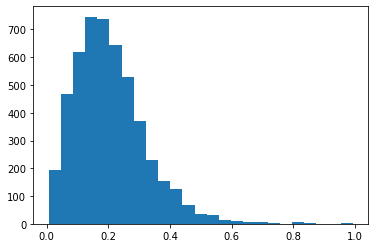

In [66]:
plt.hist(true_params[:, -2], bins=25)
# plt.xlim(0, 0.15)

In [64]:
from popsed.models import NMF_ZH
model = NMF_ZH(burst=True, peraa=True)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [63]:
params = np.hstack([_samples[:, -1:], _samples[:, :-1]])

In [69]:
sfr = np.zeros(len(params))
age = np.zeros(len(params))
zmw = np.zeros(len(params))

for i in range(len(params)):
    tt = params[i]
    sfr[i] = model.avgSFR(tt[:-1], zred=tt[-1], dt=1)
    age[i] = model.tage_MW(tt[:-1], zred=tt[-1])
    zmw[i] = model.Z_MW(tt[:-1], zred=tt[-1])

In [78]:
redshift = params[:, -1]
logmstar = params[:, 0]
logzsol = np.log10(zmw / 0.019)

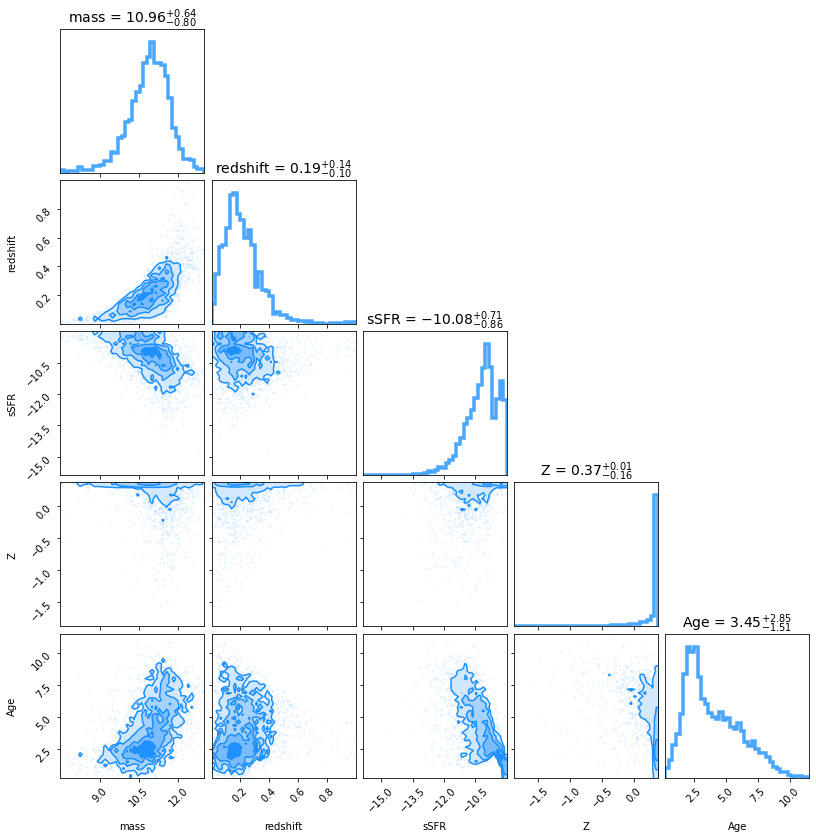

In [79]:
figure = corner.corner(np.vstack([logmstar, redshift, np.log10(sfr)-logmstar, logzsol, age]).T, 
                  labels=['mass','redshift', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = figure.get_axes()[2]
# ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

In [35]:
a, b = np.histogram(z_mass_truth[:, 0].ravel(), bins=35, range=(0, 0.5))
b[np.argmax(a)]

0.15714286

In [59]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()

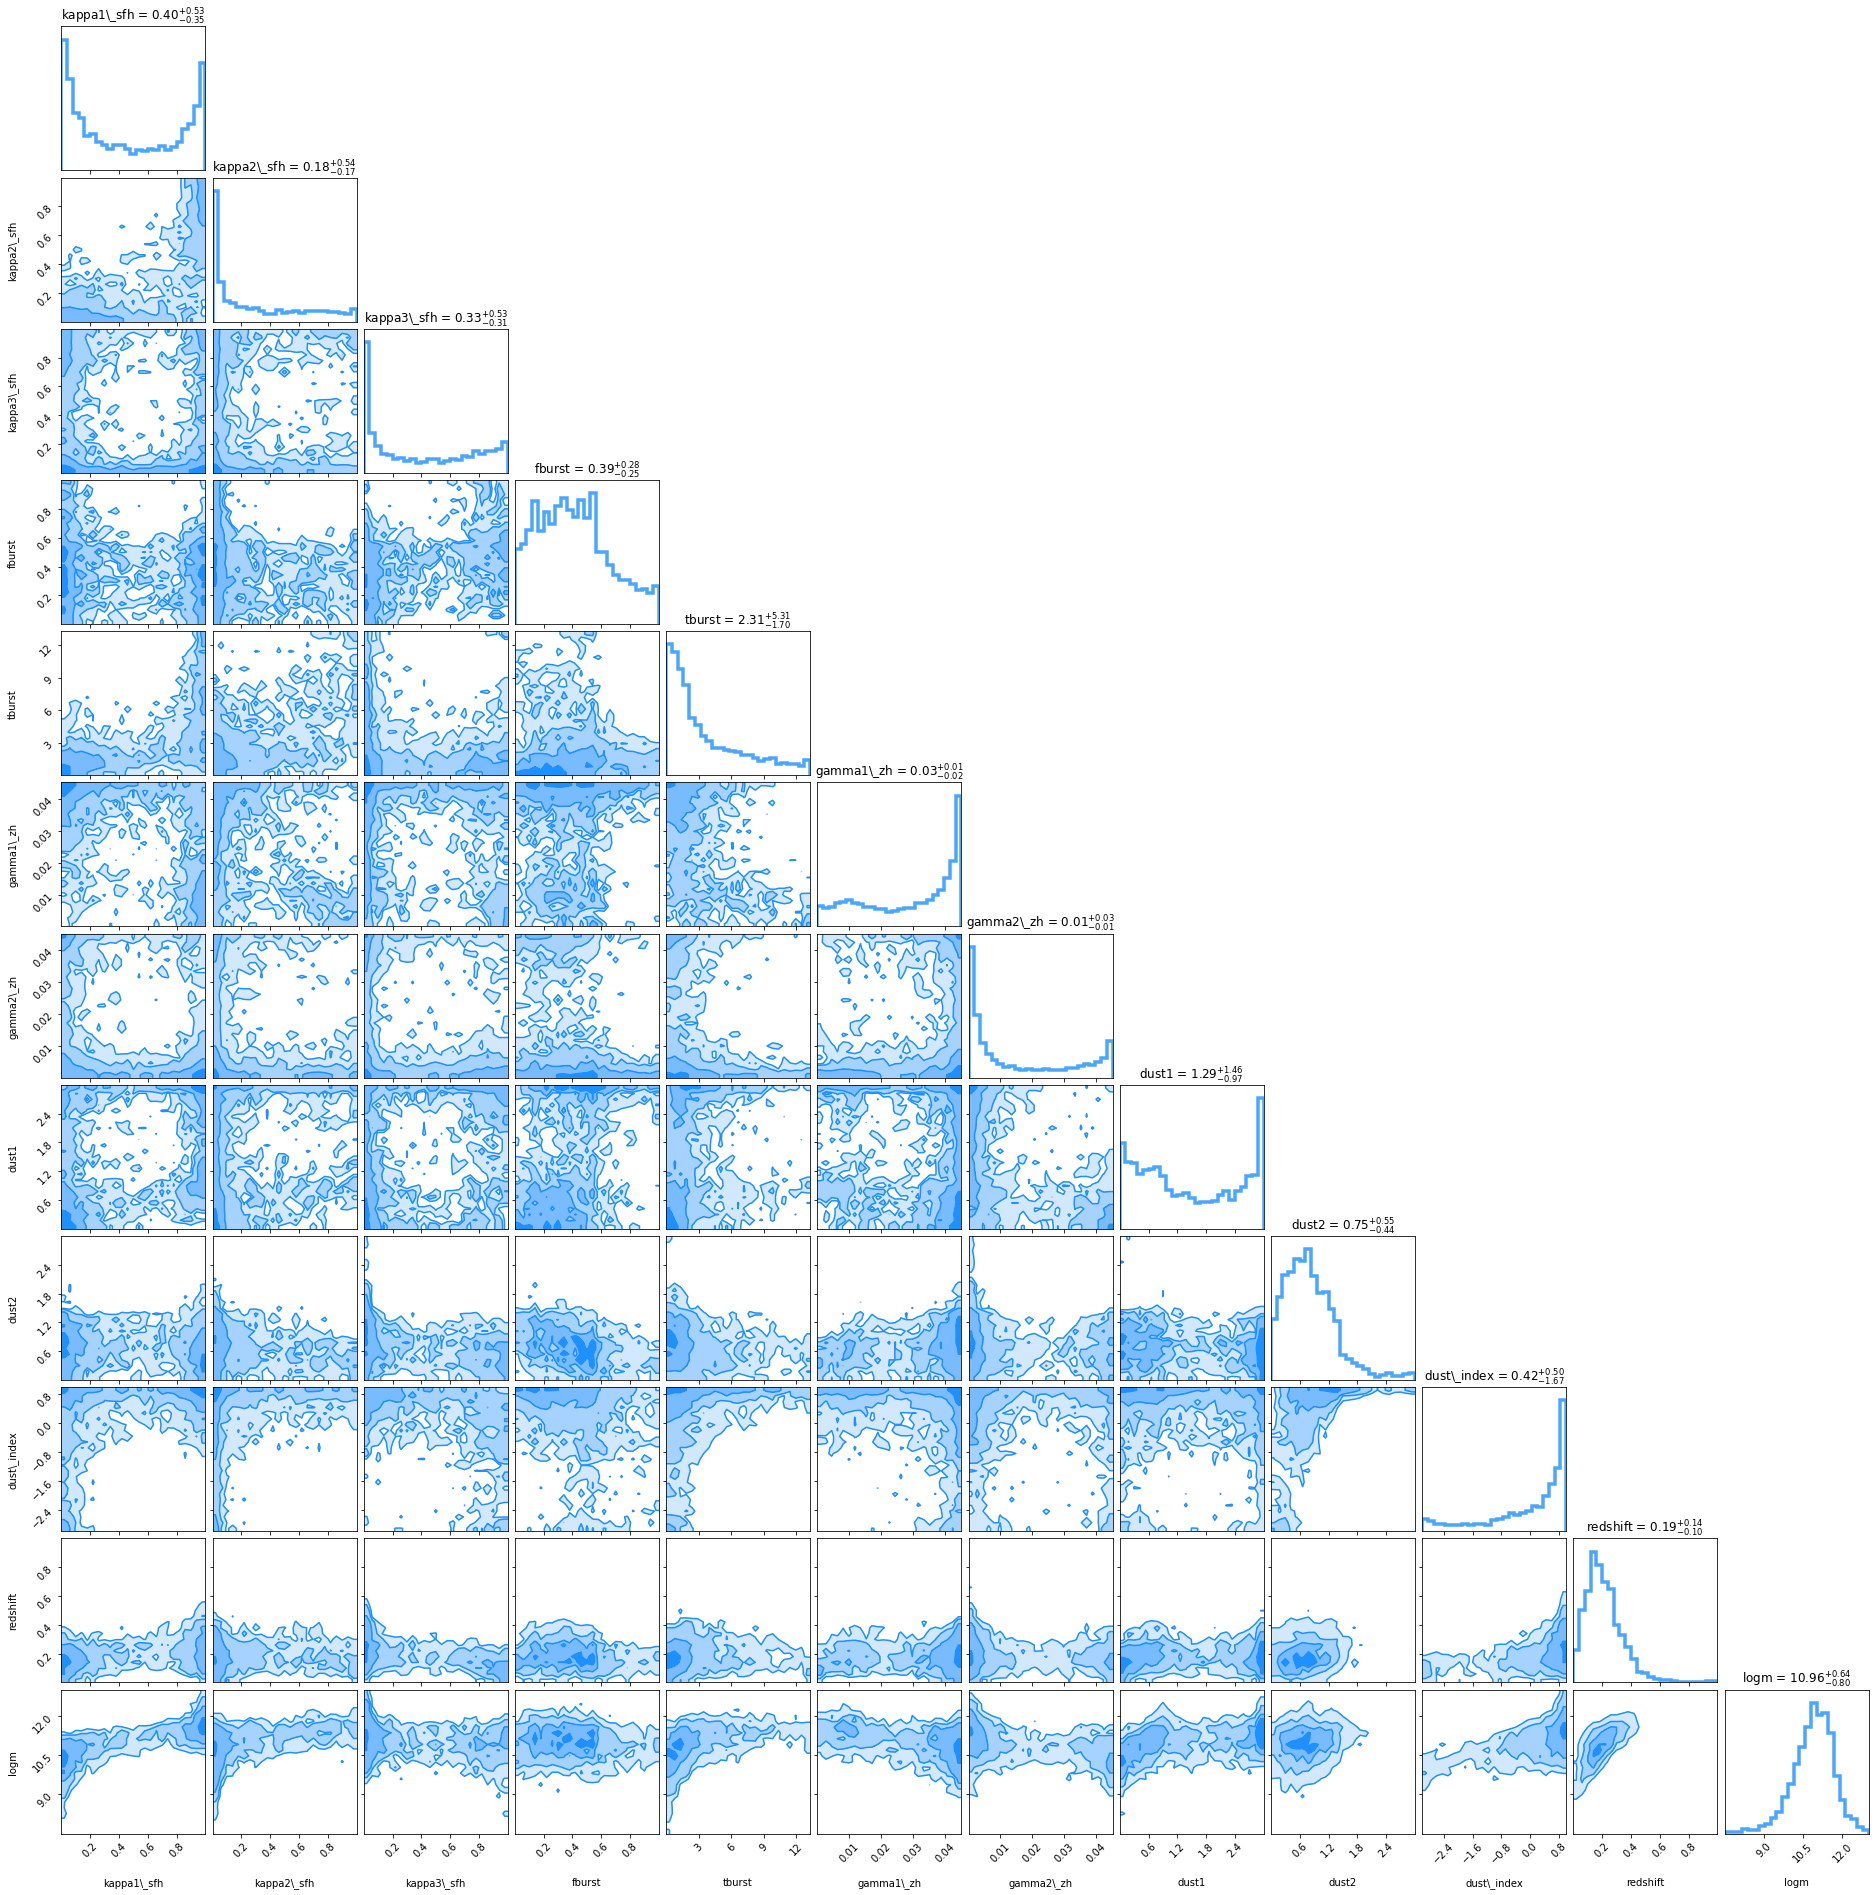

In [60]:
_labels = [f'kappa{i}_sfh' for i in range(1,4)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]

nf_plot = corner.corner(_samples_unt, 
                  labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=False)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))